In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import sys

from collections import defaultdict, OrderedDict
matplotlib.style.use('ggplot')

# import RidiculusTaxi
import mytaxi

In [2]:
env = gym.make('Taxi-v3').unwrapped
numS = env.observation_space.n
numA = env.action_space.n
print("#state:{}, #action{}".format(numS, numA))

#state:501, #action6


In [3]:
def my_argmax(Q_s):
    qmax = np.max(Q_s)
    actions = []
    for i,q in enumerate(Q_s):
        if q == qmax:
            actions.append(i)
    action=np.random.choice(actions)
    return action

def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
#         best_action = np.argmax(Q[observation])
        best_action = my_argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        A = A/sum(A)
        return A
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = make_epsilon_greedy_policy(Q, epsilon, numA)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        done = False
#         while not done:
        for t in range(1000):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            # The policy is improved implicitly by changing the Q dictionary
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
    return Q, policy

In [5]:
def plot_value_function(V, baseline, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    V_ordered = OrderedDict(sorted(V.items()))
    
    print('\n')
    print(len(V.keys()))
    
    v_s = np.zeros(len(V.keys()))
    idx = 0
    for key, val in V_ordered.items():
        v_s[idx] = val
        idx +=1

    # print(np.sort(np.asarray(V.keys())))

#     plt.plot(np.asarray(v_s), marker='o',linewidth=2)
    plt.plot(v_s,marker='o',linestyle='None',label='mc')
    plt.plot(baseline,marker='x',linestyle='None',label='base')
    plt.legend(["MC", "Baseline"])
    plt.title(title)
    plt.xlabel("State", fontsize=20)
    plt.savefig("MC_control.png")

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=100000, epsilon=0.1)
print("Q:{}".format(type(Q)))
print(Q.keys())

Episode 100000/100000.Q:<class 'collections.defaultdict'>
dict_keys([91, 191, 291, 391, 371, 471, 491, 271, 251, 351, 451, 331, 231, 131, 151, 171, 71, 51, 211, 111, 11, 311, 411, 31, 419, 319, 219, 119, 19, 39, 139, 159, 59, 179, 279, 299, 399, 499, 379, 479, 199, 99, 79, 87, 67, 167, 267, 147, 247, 47, 127, 27, 347, 447, 107, 207, 307, 7, 227, 427, 327, 367, 467, 487, 387, 287, 407, 344, 324, 224, 204, 104, 124, 4, 24, 144, 164, 44, 64, 184, 284, 264, 364, 244, 444, 424, 84, 384, 484, 304, 404, 464, 96, 76, 56, 176, 276, 256, 376, 396, 296, 496, 476, 156, 136, 356, 336, 236, 436, 472, 456, 216, 316, 416, 408, 308, 208, 228, 108, 128, 148, 168, 68, 88, 188, 288, 388, 488, 368, 268, 248, 328, 428, 348, 48, 28, 448, 8, 102, 2, 22, 122, 142, 242, 342, 322, 422, 442, 222, 262, 162, 202, 302, 402, 18, 118, 138, 38, 158, 258, 238, 358, 338, 438, 218, 42, 62, 282, 382, 362, 482, 462, 82, 182, 413, 313, 213, 113, 133, 33, 233, 253, 153, 173, 273, 373, 393, 293, 473, 477, 497, 377, 277, 297, 3



500


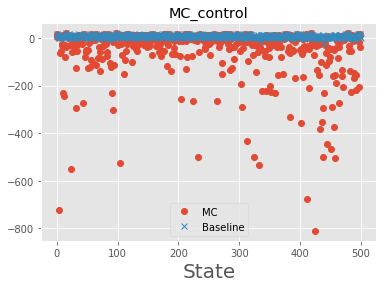

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
baseline = np.load('baseline.npy')
plot_value_function(V, baseline, title="MC_control")
# plot_Q_table()
with open('qtable_mc','w') as fp:
    fp.write(str(Q))